<font size="8">Trace Analysis Examples</font>
<br>
<font size="5">Tasks Latencies</font>
<br>
<hr>

# Import Required Modules

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)

In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support for workload generation
from wlgen import RTA, Ramp

# Support for trace analysis
from trace import Trace
from trace_analysis import TraceAnalysis

# Support for plotting
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import trappy

# Target Configuration

In [3]:
# Setup target configuration
my_conf = {

    # Target platform and board
    "platform"    : 'linux',
    "board"       : 'juno',
    "host"        : '192.168.0.1',

    # Folder where all the results will be collected
    "results_dir" : "TraceAnalysis_TaskLatencies",

    # Define devlib modules to load
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
        ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],
    
    # Comment this line to calibrate RTApp in your own platform
    "rtapp-calib" :  {"0": 360, "1": 142, "2": 138, "3": 352, "4": 352, "5": 353},
}

In [4]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

06:20:34  INFO    :         Target - Using base path: /home/derkling/Code/lisa
06:20:34  INFO    :         Target - Loading custom (inline) target configuration
06:20:34  INFO    :         Target - Devlib modules to load: ['bl', 'cpufreq']
06:20:34  INFO    :         Target - Connecting linux target:
06:20:34  INFO    :         Target -   username : root
06:20:34  INFO    :         Target -       host : 192.168.0.1
06:20:34  INFO    :         Target -   password : 
06:20:34  INFO    :         Target - Connection settings:
06:20:35  INFO    :         Target -    {'username': 'root', 'host': '192.168.0.1', 'password': ''}
06:20:39  INFO    :         Target - Initializing target workdir:
06:20:39  INFO    :         Target -    /root/devlib-target
06:20:45  INFO    :         Target - Topology:
06:20:45  INFO    :         Target -    [[0, 3, 4, 5], [1, 2]]
06:20:47  INFO    :       Platform - Loading default EM:
06:20:47  INFO    :       Platform -    /home/derkling/Code/lisa/libs/utils/pla

# Workload Execution

In [5]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

06:20:49  INFO    :          WlGen - Setup new workload ramp
06:20:49  INFO    :          RTApp - Workload duration defined by longest task
06:20:49  INFO    :          RTApp - Default policy: SCHED_OTHER
06:20:49  INFO    :          RTApp - ------------------------
06:20:49  INFO    :          RTApp - task [ramp], sched: using default policy
06:20:49  INFO    :          RTApp -  | calibration CPU: 1
06:20:49  INFO    :          RTApp -  | loops count: 1
06:20:49  INFO    :          RTApp - + phase_000001: duration 0.500000 [s] (5 loops)
06:20:49  INFO    :          RTApp - |  period   100000 [us], duty_cycle  60 %
06:20:49  INFO    :          RTApp - |  run_time  60000 [us], sleep_time  40000 [us]
06:20:49  INFO    :          RTApp - + phase_000002: duration 0.500000 [s] (5 loops)
06:20:49  INFO    :          RTApp - |  period   100000 [us], duty_cycle  55 %
06:20:49  INFO    :          RTApp - |  run_time  55000 [us], sleep_time  45000 [us]
06:20:49  INFO    :          RTApp - + phas

# Parse Trace and Profiling Data

In [7]:
# Base folder where tests folder are located
# res_dir = te.res_dir
res_dir = '/home/derkling/Code/lisa/results/TraceAnalysis_TaskLatencies'
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

06:21:06  INFO    : Content of the output folder /home/derkling/Code/lisa/results/TraceAnalysis_TaskLatencies


/home/derkling/Code/lisa/results/TraceAnalysis_TaskLatencies
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
└── trace.dat

0 directories, 5 files


In [8]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

06:21:06  INFO    : LITTLE cluster max capacity: 447


In [9]:
trace_file = os.path.join(res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

06:21:06  INFO    : Parsing FTrace format...
06:21:07  INFO    : Collected events spans a 7.607 [s] time interval
06:21:07  INFO    : Set plots time range to (0.000000, 7.606709)[s]
06:21:07  INFO    : Registering trace analysis modules:
06:21:07  WARNING :       No performance data found in:
06:21:07  WARNING :         /home/derkling/Code/lisa/results/TraceAnalysis_TaskLatencies
06:21:07  INFO    :    perf
06:21:07  INFO    :    latency
06:21:07  INFO    :    eas
06:21:07  INFO    :    tasks
06:21:07  INFO    :    cpus
06:21:07  INFO    :    functions
06:21:07  INFO    :    status
06:21:07  INFO    :    frequency


# Trace visualization

In [10]:
trappy.plotter.plot_trace(trace.ftrace)

# Latency DataFrames

In [11]:
# Report full set of task status informations available from the trace
trace.data_frame.latency_df('ramp').head()

,target_cpu,__cpu,curr_state,next_state,t_start,t_delta
Time,,,,,,
1.418353,NaN,2,A,1,1.418353,0.061676
1.480029,NaN,2,1,W,1.480029,0.038816
1.518845,2,NaN,W,A,1.518845,0.000134
1.518979,NaN,2,A,1,1.518979,0.063921
1.582900,NaN,2,1,W,1.582900,0.036216


In [12]:
# Report WAKEUP events and their duration
trace.data_frame.latency_wakeup_df('ramp').head()

,wakeup_latency
Time,
1.518845,0.000134
1.619116,0.000322
1.718915,0.000132
1.818842,0.000143
1.918841,0.000131


In [13]:
# Report PREEMPTION events and their duration
trace.data_frame.latency_preemption_df('ramp').head()

,preempt_latency
Time,
2.320453,0.000344
2.348149,0.000315
2.349654,0.000144
2.349865,0.000105
2.420452,0.000332


## Latency Plots

06:21:08  INFO    : Found:    45 WAKEUP latencies
06:21:08  INFO    : Found:   119 PREEMPT latencies
06:21:08  INFO    : Total:   164 latency events
06:21:08  WARNING : Event [sched_overutilized] not found, plot DISABLED!


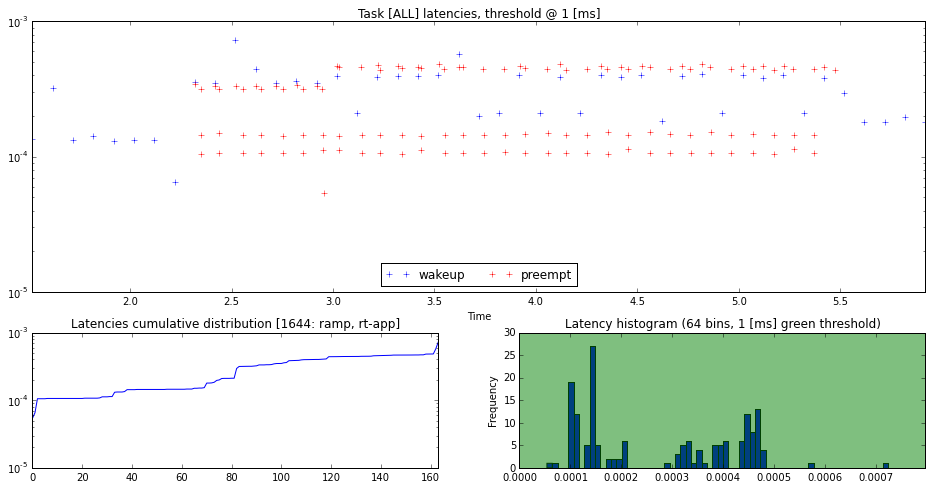

In [14]:
# Plot latency events for a specified task
latency_stats_df = trace.analysis.latency.plotLatency('ramp')

In [15]:
# Plot statistics on task latencies
latency_stats_df.T

,count,mean,std,min,50%,95%,99%,max
latency,164,0.000276,0.00015,0.000054,0.000253,0.000466,0.000516,0.000725


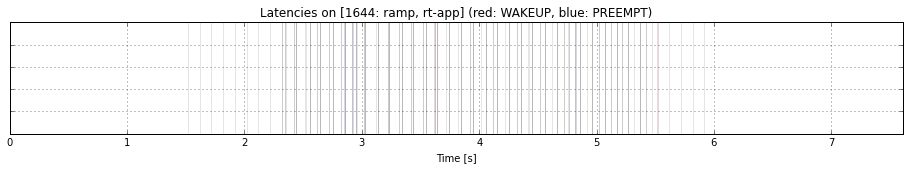

In [16]:
# Plot latency events for a specified task
trace.analysis.latency.plotLatencyBands('ramp')

06:21:49  INFO    : Set plots time range to (3.510000, 3.590000)[s]


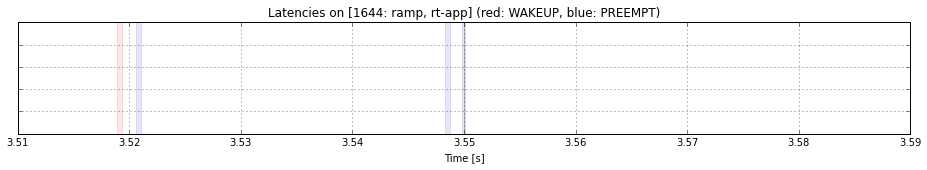

In [18]:
# Zoom into a spefific time frame
trace.setXTimeRange(3.51, 3.59)
trace.analysis.latency.plotLatencyBands('ramp')